In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series


def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern


def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

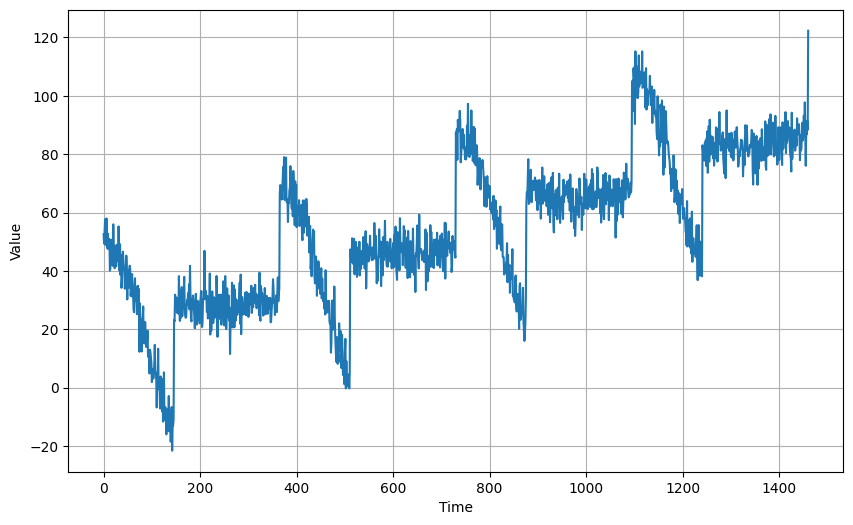

In [4]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)


In [11]:
split_time =1000

time_train= time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

print(x_train.shape)
print(x_valid.shape)

(1000,)
(461,)


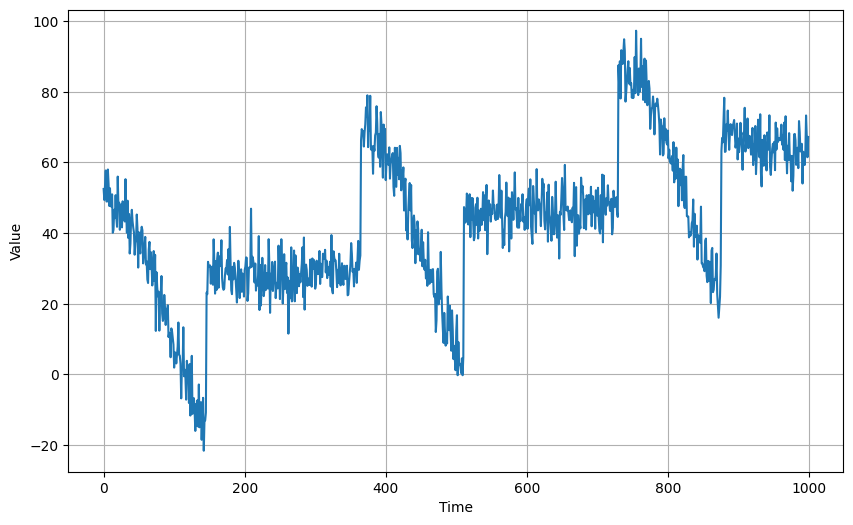

In [10]:
# Plot the train set
plot_series(time_train, x_train)

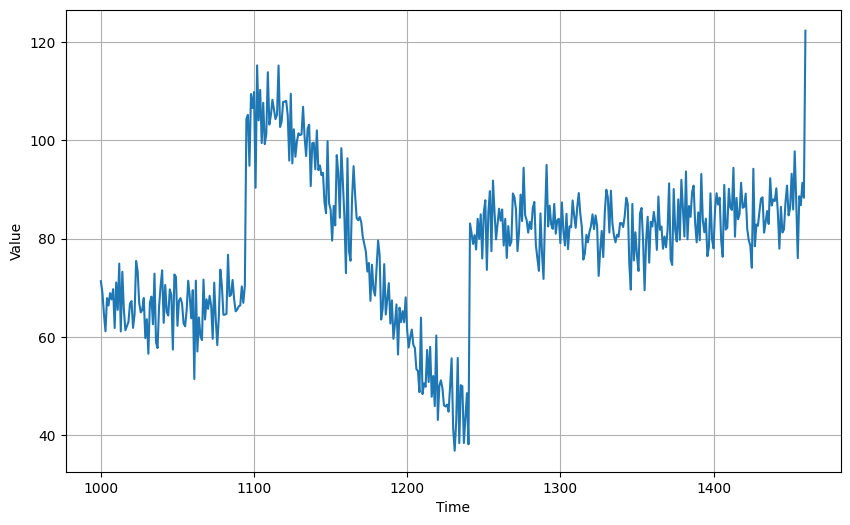

In [12]:
# Plot the validation set
plot_series(time_valid, x_valid)

In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [17]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [18]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [19]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


2024-04-18 10:01:44.540294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [21]:
l0 = tf.keras.layers.Dense(units=1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

print(f"Layer wieghts : {l0.get_weights()}")

model.summary()

Layer wieghts : [array([[-0.06430715],
       [-0.43933353],
       [ 0.0349232 ],
       [-0.30867416],
       [-0.28906775],
       [ 0.16387522],
       [ 0.03538144],
       [-0.14311546],
       [ 0.1772303 ],
       [ 0.03114396],
       [-0.48953128],
       [-0.0481953 ],
       [ 0.42053586],
       [-0.26347485],
       [-0.26953095],
       [ 0.42382163],
       [ 0.2824847 ],
       [-0.16823238],
       [ 0.19963837],
       [-0.0442909 ]], dtype=float32), array([0.], dtype=float32)]


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21 (84.00 B)

 Trainable params: 21 (84.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(momentum=0.9, learning_rate=1e-6))

In [23]:
history = model.fit(dataset, epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2515.8779
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 208.0516
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 96.2024
Epoch 4/100


2024-04-18 10:10:42.364347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/geonheekim/miniforge3/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-04-18 10:10:42.451180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:42.534148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 76.6434
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 79.7452
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 90.2591
Epoch 7/100


2024-04-18 10:10:42.618826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:42.701434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:42.784408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 77.9046
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 81.5184
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 72.7710
Epoch 10/100


2024-04-18 10:10:42.871300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:42.954907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:43.036779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 74.1957
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 72.8840
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 79.0718
Epoch 13/100


2024-04-18 10:10:43.128580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:43.211672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:43.297622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 64.0895
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 69.2853
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 70.2544
Epoch 16/100


2024-04-18 10:10:43.386095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:43.471736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:43.552413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 65.3330
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 69.0480
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 56.7257
Epoch 19/100


2024-04-18 10:10:43.635278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:43.716192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:43.796178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 62.3907
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 61.4097
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 57.5791
Epoch 22/100


2024-04-18 10:10:43.879586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:43.964077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:44.048176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 59.2154
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 59.3868
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - loss: 60.0964
Epoch 25/100


2024-04-18 10:10:44.130769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:44.211226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:44.291040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 56.8200
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 60.0370
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 58.6829
Epoch 28/100


2024-04-18 10:10:44.369933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:44.449277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:44.536141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 58.8770
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 56.0251
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 65.8860
Epoch 31/100


2024-04-18 10:10:44.620782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:44.701299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:44.781703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 54.5097
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 66.4356
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 55.1820
Epoch 34/100


2024-04-18 10:10:44.865025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:44.948468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:45.032559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 53.3530
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 51.2801
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 56.0573
Epoch 37/100


2024-04-18 10:10:45.117193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:45.198663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:45.278282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 55.1893
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 52.8634
Epoch 39/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 61.8309
Epoch 40/100


2024-04-18 10:10:45.359634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:45.440887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:45.519705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 48.6385
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 44.9712
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 52.5735
Epoch 43/100


2024-04-18 10:10:45.602892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:45.682710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:45.766448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 57.4399 
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 52.0685
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 50.4681
Epoch 46/100


2024-04-18 10:10:45.855532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:45.947339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:46.026763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 47.3362
Epoch 47/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 43.6945
Epoch 48/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 50.0519
Epoch 49/100


2024-04-18 10:10:46.108304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:46.187864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:46.272350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 53.9470
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 53.6269
Epoch 51/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 45.9472
Epoch 52/100


2024-04-18 10:10:46.355431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:46.435413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:46.515147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 50.1981
Epoch 53/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 46.8777
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 53.7245
Epoch 55/100


2024-04-18 10:10:46.595368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:46.674832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:46.754870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 49.0910
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 54.0906
Epoch 57/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 49.6651
Epoch 58/100


2024-04-18 10:10:46.842094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:46.924812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:47.009851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 52.2860
Epoch 59/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 54.7676
Epoch 60/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 44.5351
Epoch 61/100


2024-04-18 10:10:47.095009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:47.175512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:47.254912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 41.9218
Epoch 62/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 46.6782
Epoch 63/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 43.5157
Epoch 64/100


2024-04-18 10:10:47.339276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:47.422113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:47.507040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 49.8399
Epoch 65/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 43.5928
Epoch 66/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 48.1368
Epoch 67/100


2024-04-18 10:10:47.595737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:47.678149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:47.758697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 45.5674
Epoch 68/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 51.5130
Epoch 69/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 41.9992
Epoch 70/100


2024-04-18 10:10:47.841565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:47.925137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:48.004524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 47.0512
Epoch 71/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 46.3116
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 46.2390
Epoch 73/100


2024-04-18 10:10:48.087501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:48.170263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:48.253861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 46.8878
Epoch 74/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 47.1133
Epoch 75/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 46.5737
Epoch 76/100


2024-04-18 10:10:48.336215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:48.415716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:48.494867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 47.1873
Epoch 77/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 49.5125
Epoch 78/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 46.9558
Epoch 79/100


2024-04-18 10:10:48.576103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:48.655929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:48.736198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42.2751 
Epoch 80/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 41.9406
Epoch 81/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 44.7156
Epoch 82/100


2024-04-18 10:10:48.819280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:48.917521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:49.000813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 48.1870
Epoch 83/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 42.6880
Epoch 84/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 44.4486
Epoch 85/100


2024-04-18 10:10:49.086422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:49.170258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:49.255196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 47.1574
Epoch 86/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 49.7292
Epoch 87/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 53.5271
Epoch 88/100


2024-04-18 10:10:49.339644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:49.428595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:49.516661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 41.7299
Epoch 89/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 44.0197
Epoch 90/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 44.3661
Epoch 91/100


2024-04-18 10:10:49.602053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:49.690826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:49.776479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 50.4939
Epoch 92/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 44.6661
Epoch 93/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 44.1876
Epoch 94/100


2024-04-18 10:10:49.860957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:49.942480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:50.030093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 47.2785
Epoch 95/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 42.8735
Epoch 96/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 44.4719
Epoch 97/100


2024-04-18 10:10:50.111087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:50.192050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:50.277524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 44.8010
Epoch 98/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 43.6616
Epoch 99/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 41.3383
Epoch 100/100


2024-04-18 10:10:50.383283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:50.470161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:10:50.551225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 43.9280


2024-04-18 10:10:50.634295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [25]:
print(f"Layer weights -> {l0.get_weights()}")

Layer weights -> [array([[-1.49012934e-02],
       [-5.41206449e-02],
       [ 7.94099048e-02],
       [-3.35199684e-02],
       [-3.66221159e-03],
       [ 3.79930586e-02],
       [-7.20266835e-05],
       [-1.97986476e-02],
       [ 3.43745314e-02],
       [ 3.04847732e-02],
       [-8.96111652e-02],
       [-2.18748581e-04],
       [ 5.89985587e-02],
       [-1.62686165e-02],
       [-4.22310904e-02],
       [ 1.18681304e-01],
       [ 7.76400790e-02],
       [ 1.20957568e-01],
       [ 2.88641304e-01],
       [ 4.29465711e-01]], dtype=float32), array([0.0168612], dtype=float32)]


In [27]:
series[0:20]

array([52.48357 , 49.35275 , 53.314735, 57.711823, 48.934444, 48.931244,
       57.982895, 53.897125, 47.67393 , 52.68371 , 47.591717, 47.506374,
       50.959415, 40.086178, 40.919415, 46.612473, 44.228207, 50.720642,
       44.454983, 41.76799 ], dtype=float32)

In [29]:
series[0:20][np.newaxis]

array([[52.48357 , 49.35275 , 53.314735, 57.711823, 48.934444, 48.931244,
        57.982895, 53.897125, 47.67393 , 52.68371 , 47.591717, 47.506374,
        50.959415, 40.086178, 40.919415, 46.612473, 44.228207, 50.720642,
        44.454983, 41.76799 ]], dtype=float32)

In [31]:
np.expand_dims(series[0:20], axis=0)

array([[52.48357 , 49.35275 , 53.314735, 57.711823, 48.934444, 48.931244,
        57.982895, 53.897125, 47.67393 , 52.68371 , 47.591717, 47.506374,
        50.959415, 40.086178, 40.919415, 46.612473, 44.228207, 50.720642,
        44.454983, 41.76799 ]], dtype=float32)

In [26]:
# Shape of the first 20 data points slice
print(f'shape of series[0:20]: {series[0:20].shape}')

# Shape after adding a batch dimension
print(f'shape of series[0:20][np.newaxis]: {series[0:20][np.newaxis].shape}')

# Shape after adding a batch dimension (alternate way)
print(f'shape of series[0:20][np.newaxis]: {np.expand_dims(series[0:20], axis=0).shape}')

# Sample model prediction
print(f'model prediction: {model.predict(series[0:20][np.newaxis])}')

shape of series[0:20]: (20,)
shape of series[0:20][np.newaxis]: (1, 20)
shape of series[0:20][np.newaxis]: (1, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
model prediction: [[44.937992]]


In [32]:
forecast = []

for time in range(len(series)-window_size):
    forecast.append(model.predict(series[time:time+window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [33]:
# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_valid.shape}')

length of the forecast list: 461
shape of the validation set: (461,)


shape after converting to numpy array: (461, 1, 1)
shape after squeezing: (461,)


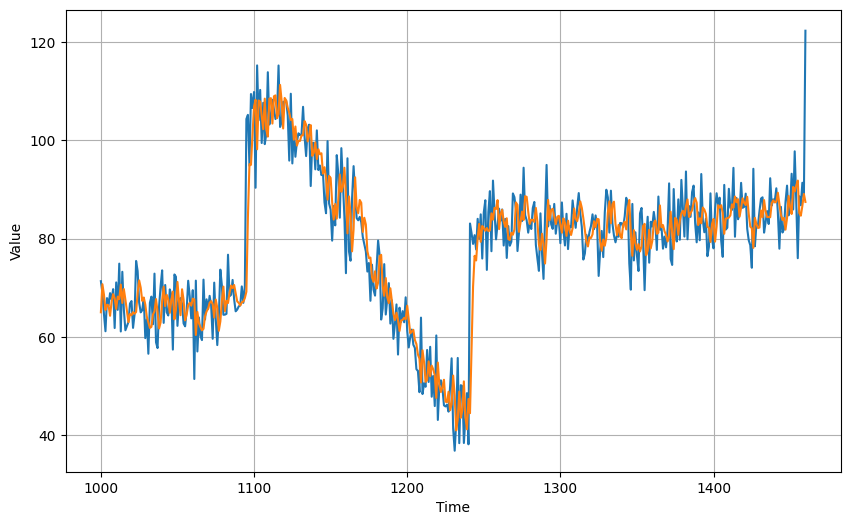

In [35]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(time_valid, (x_valid, results))

In [40]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

45.70831
5.035314
